In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scicm

import unyt
import swiftsimio as sw
from swiftgalaxy import SWIFTGalaxy, SOAP
from swiftgalaxy.iterator import SWIFTGalaxies

from scipy.spatial.transform import Rotation

In [5]:
snap = "0123"
zshort = "0.0"

colibre_base_path = "/mnt/su3-pro/colibre/"
simulation_dir = "L0025N0752/THERMAL_AGN"

soap_path = "SOAP/halo_properties_"+snap+".hdf5"
soap_catalogue_file = os.path.join(colibre_base_path, simulation_dir, soap_path)
virtual_snapshot_path = "SOAP/colibre_with_SOAP_membership_"+snap+".hdf5"
virtual_snapshot_file = os.path.join(colibre_base_path, simulation_dir, virtual_snapshot_path)

table_file = "tables/targets_L0025_N0752_z"+zshort+".npy"

In [20]:
targets = np.load(table_file).T.squeeze()
print(targets)

[    479   12834   21662   63640   72921   95758  117225  123105  126101
  138682  139503  168669  169324  171447  185981  196915  199853  202239
  202278  207333  210491  230185  234497  247235  279746  311056  314117
  325527  337295  341961  344983  350948  369465  375108  389320  395325
  400067  411472  449105  488624  502496  515676  566723  569079  584263
  704069  732277  748771  772669  803198  839320  870783  871854  886409
  938624  939807  941998  946322  958476  959270  970084 1015322 1025801
 1028096 1041630 1064168 1075667 1092917 1096215 1099354 1099962 1118204
 1126633 1150500 1167626 1174529 1176585 1179468 1199099]


In [27]:
sg = SWIFTGalaxy(
    virtual_snapshot_file,
    SOAP(
        soap_catalogue_file,
        soap_index=targets[0]
    ),
)

Lstars = sg.halo_catalogue.exclusive_sphere_30kpc.angular_momentum_stars.squeeze() #10kpc, 30kpc?
zhat = (Lstars / np.sqrt(np.sum(Lstars**2))).to_value(
    unyt.dimensionless
)  # we'll align L with the z-axis
arb = np.ones(3) / np.sqrt(
    3
)  # we have one degree of freedom, we'll fix it by projecting onto an arbitrarily chosen vector
xvec = arb - arb.dot(zhat) * zhat
xhat = xvec / np.sum(xvec**2)
yhat = np.cross(zhat, xhat)  # orthogonal, right-handed and normalized
rotmat = np.vstack((xhat, yhat, zhat)).T
sg.rotate(Rotation.from_matrix(rotmat)) # hopefully this puts the galaxy face-on

In [67]:
R50 = sg.halo_catalogue.exclusive_sphere_30kpc.half_mass_radius_stars.to_physical()

xpos = sg.gas.coordinates[:,0].to_physical()
ypos = sg.gas.coordinates[:,1].to_physical()
rpos = np.sqrt(xpos**2 + ypos**2)
indisk = (rpos <= 3*R50)
zpos = sg.gas.coordinates[:,2].to_physical()

zvel = sg.gas.velocities[:,2].to_physical()

gastemp = sg.gas.temperatures.to_physical()
warm = (gastemp < 10**4*unyt.K)


HIIfrac = sg.gas.species_fractions.HII.to_physical()
H2frac = sg.gas.species_fractions.H2.to_physical()
Hmassfrac = sg.gas.element_mass_fractions.hydrogen.to_physical()
gasmass = sg.gas.masses.to_physical()

H2mass = 2*H2frac * Hmassfrac * gasmass
HIImass = HIIfrac * Hmassfrac * gasmass

/home/jmcgregor/envs/colibre_env/lib/python3.10/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=0.9999999999999997) for all arguments.
  warnings.warn(


In [68]:
H2masstotal = np.sum(H2mass[indisk])
HIImasstotal = np.sum(HIImass[indisk&warm])

H2disp = np.sqrt(np.sum(H2mass[indisk]*zvel[indisk]**2)/H2masstotal)
print(H2disp.to(unyt.km/unyt.s))

HIIdisp = np.sqrt(np.sum(HIImass[indisk&warm]*zvel[indisk&warm]**2)/HIImasstotal)
print(HIIdisp.to(unyt.km/unyt.s))

13.278138730252827 km/s (Physical)
60.242070004032556 km/s (Physical)


In [71]:
shlist = targets[:5]
H2disps = np.zeros_like(shlist,dtype=float)*(unyt.km/unyt.s)
HIIdisps = np.zeros_like(shlist,dtype=float)*(unyt.km/unyt.s)

for i, ID in enumerate(shlist):
    print(i, ID)
    sg = SWIFTGalaxy(
        virtual_snapshot_file,
        SOAP(
            soap_catalogue_file,
            soap_index=ID
        ),
    )

    Lstars = sg.halo_catalogue.exclusive_sphere_30kpc.angular_momentum_stars.squeeze() #10kpc, 30kpc?
    zhat = (Lstars / np.sqrt(np.sum(Lstars**2))).to_value(
        unyt.dimensionless
    )  # we'll align L with the z-axis
    arb = np.ones(3) / np.sqrt(
        3
    )  # we have one degree of freedom, we'll fix it by projecting onto an arbitrarily chosen vector
    xvec = arb - arb.dot(zhat) * zhat
    xhat = xvec / np.sum(xvec**2)
    yhat = np.cross(zhat, xhat)  # orthogonal, right-handed and normalized
    rotmat = np.vstack((xhat, yhat, zhat)).T
    sg.rotate(Rotation.from_matrix(rotmat)) # hopefully this puts the galaxy face-on

    R50 = sg.halo_catalogue.exclusive_sphere_30kpc.half_mass_radius_stars.to_physical()

    xpos = sg.gas.coordinates[:,0].to_physical()
    ypos = sg.gas.coordinates[:,1].to_physical()
    rpos = np.sqrt(xpos**2 + ypos**2)
    indisk = (rpos <= 3*R50)
    zpos = sg.gas.coordinates[:,2].to_physical()

    zvel = sg.gas.velocities[:,2].to_physical()

    gastemp = sg.gas.temperatures.to_physical()
    warm = (gastemp < 10**4*unyt.K)

    HIIfrac = sg.gas.species_fractions.HII.to_physical()
    H2frac = sg.gas.species_fractions.H2.to_physical()
    Hmassfrac = sg.gas.element_mass_fractions.hydrogen.to_physical()
    gasmass = sg.gas.masses.to_physical()

    H2mass = 2*H2frac * Hmassfrac * gasmass
    HIImass = HIIfrac * Hmassfrac * gasmass

    H2masstotal = np.sum(H2mass[indisk])
    HIImasstotal = np.sum(HIImass[indisk&warm])

    H2disp = np.sqrt(np.sum(H2mass[indisk]*zvel[indisk]**2)/H2masstotal)
    H2disps[i] = H2disp
    print(H2disp.to(unyt.km/unyt.s))


    HIIdisp = np.sqrt(np.sum(HIImass[indisk&warm]*zvel[indisk&warm]**2)/HIImasstotal)
    HIIdisps[i] = HIIdisp
    print(HIIdisp.to(unyt.km/unyt.s))
    print()


0 479


/home/jmcgregor/envs/colibre_env/lib/python3.10/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=0.9999999999999997) for all arguments.
  warnings.warn(


13.278138730252827 km/s (Physical)
60.242070004032556 km/s (Physical)

1 12834
13.843528664325826 km/s (Physical)
56.8475413875651 km/s (Physical)

2 21662
14.530020871744261 km/s (Physical)
41.39883884562946 km/s (Physical)

3 63640
15.352452428675775 km/s (Physical)
64.27070161174251 km/s (Physical)

4 72921
18.251988790402848 km/s (Physical)
82.33043986459143 km/s (Physical)



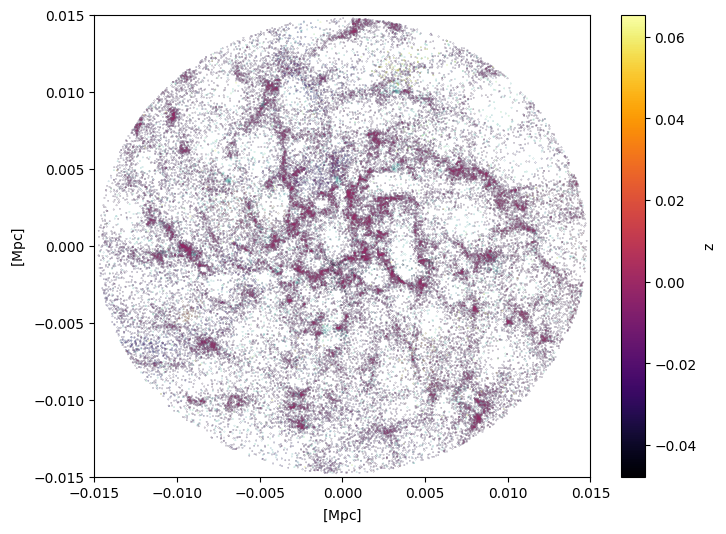

In [48]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:
    fig,ax1 = plt.subplots(figsize=(8,6))
    m1 = ax1.scatter(xpos[indisk], ypos[indisk],c=zpos[indisk],s=0.01)
    m1 = ax1.scatter(xpos[indisk&warm], ypos[indisk&warm],c=zpos[indisk&warm],s=0.01,cmap='inferno')
    ax1.set_xlim([-0.015,0.015])
    ax1.set_ylim([-0.015,0.015])
    cb1 = fig.colorbar(m1, ax=ax1,label=r'z')


    plt.show()